Notebook description

- Objective
- Content
- What to learn

In [190]:
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import graphics, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn import metrics

import datetime
from tqdm import tqdm

In [20]:
passengers = pd.read_csv("./data/airline-passengers.csv")

In [21]:
passengers.index = pd.to_datetime(passengers.Month, format="%Y-%m")
passengers = passengers.drop("Month", axis=1)

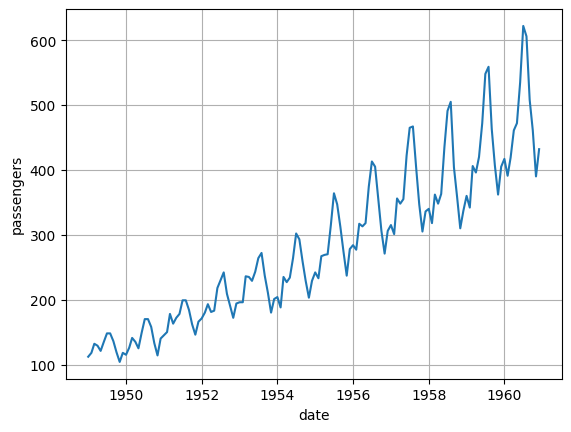

In [26]:
plt.xlabel("date")
plt.ylabel("passengers")
plt.plot(passengers)
plt.grid()


## Check stationarity

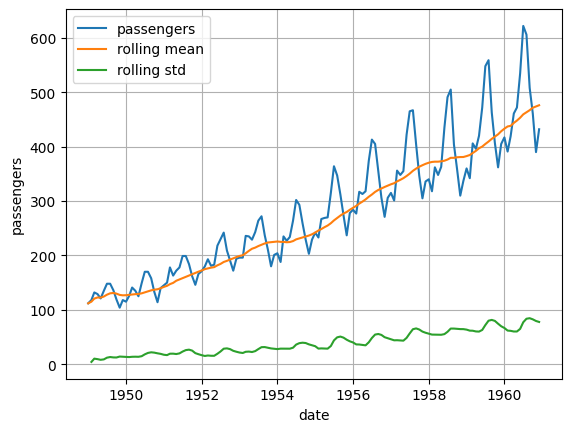

In [40]:
plt.xlabel("date")
plt.ylabel("passengers")
plt.plot(passengers, label="passengers")
plt.plot(passengers.rolling(datetime.timedelta(days=365)).mean(), label="rolling mean")
plt.plot(passengers.rolling(datetime.timedelta(days=365)).std(), label="rolling std")
plt.grid()
plt.legend()

In [52]:
def display_adfuller_test(timeseries):
    #Perform Augmented Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = statsmodels.tsa.stattools.adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

In [53]:
display_adfuller_test(passengers['Passengers'])

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


To test stationarity, we will use Augmented Dickey Fuller Test :
 - Null Hypothesis : It assumes that the time series is non-stationary.
 - Alternate Hypothesis : If the null hypothesis is rejected, then the time series is stationary.

For a Time series to be stationary, its ADCF test should have:

 - p-value to be low < 0.05 (according to the null hypothesis)
 - The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
 - Test Statistic < Critical Value (5%) 

From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary

In [60]:
display_adfuller_test((passengers['Passengers'] - passengers.rolling(12).mean()['Passengers']).dropna())

Results of Dickey Fuller Test:
Test Statistic                  -3.164968
p-value                          0.022104
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


<Axes: xlabel='Month'>

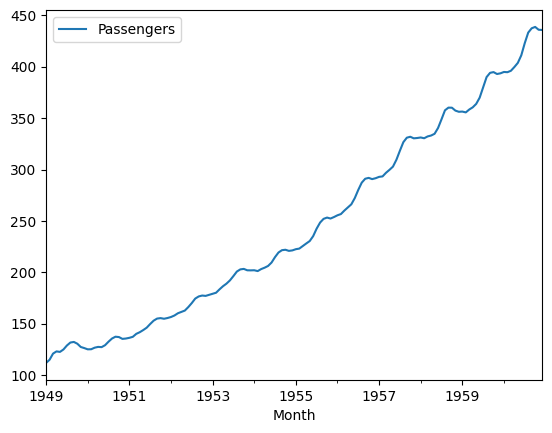

In [66]:
# exponential weighted mean
passengers.ewm(halflife=12).mean().plot()

In [75]:
dec = seasonal_decompose(passengers['Passengers'])

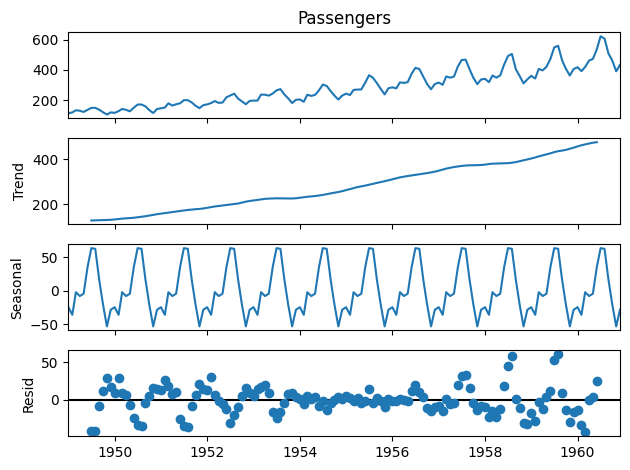

In [87]:
dec.plot()
plt.show()

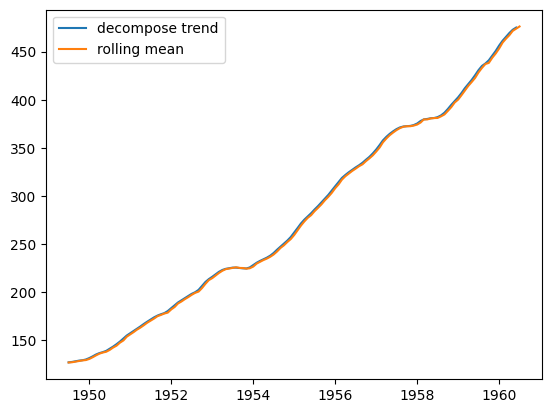

In [85]:
plt.plot(dec.trend, label="decompose trend")
plt.plot(passengers.rolling(window=12, center=True).mean(), label="rolling mean")
plt.legend()

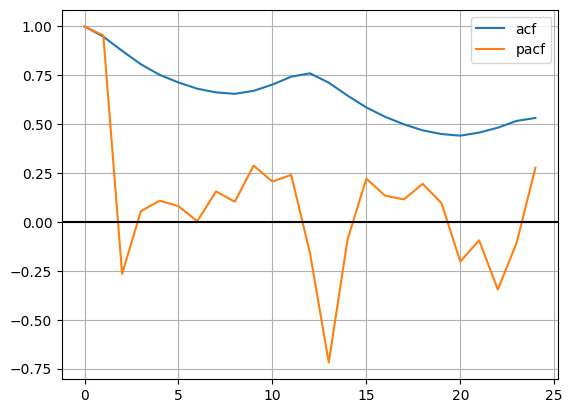

In [112]:
# graphics.plot_acf(passengers)
# plt.show()
# graphics.plot_pacf(passengers)
# plt.show()

plt.plot(acf(passengers, nlags=24), label="acf")
plt.plot(pacf(passengers, nlags=24), label="pacf")
plt.axhline(y=0, c="black")
plt.legend()
plt.grid()
plt.show()

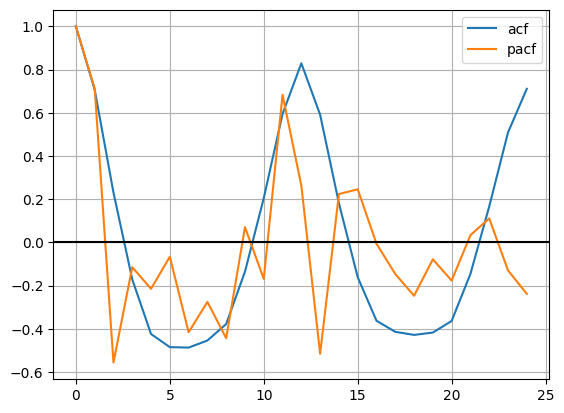

In [113]:
# graphics.plot_acf((passengers['Passengers'] - passengers.rolling(12).mean()['Passengers']).dropna())
# plt.show()
# graphics.plot_pacf((passengers['Passengers'] - passengers.rolling(12).mean()['Passengers']).dropna())
# plt.show()

plt.plot(acf((passengers['Passengers'] - passengers.rolling(12).mean()['Passengers']).dropna(), nlags=24), label="acf")
plt.plot(pacf((passengers['Passengers'] - passengers.rolling(12).mean()['Passengers']).dropna(), nlags=24), label="pacf")
plt.axhline(y=0, c="black")
plt.legend()
plt.grid()
plt.show()

## ARIMA and SARIMAX

In [213]:
p = 2
d = 1
q = 2

In [214]:
history = passengers["Passengers"][:120]

In [215]:
futur = []
for futur_idx in tqdm(range(24)):
    sarima_model = SARIMAX(history, order=(p, d, q), seasonal_order=(0, 1, 1, 12))
    sarima_model = sarima_model.fit()

    futur.append(sarima_model.forecast())
    history = pd.concat([history, sarima_model.forecast()])
futur = pd.concat(futur)

  0%|                                                                       | 0/24 [00:00<?, ?it/s]/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32397D+00    |proj g|=  5.66356D-02

At iterate    5    f=  3.31603D+00    |proj g|=  2.12586D-02

At iterate   10    f=  3.31441D+00    |proj g|=  8.03686D-03

At iterate   15    f=  3.31311D+00    |proj g|=  4.06495D-03

At iterate   20    f=  3.30985D+00    |proj g|=  1.38360D-02

At iterate   25    f=  3.30945D+00    |proj g|=  2.61347D-03

At iterate   30    f=  3.30919D+00    |proj g|=  1.40824D-03

At iterate   35    f=  3.30915D+00    |proj g|=  1.45685D-03


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  4%|██▋                                                            | 1/24 [00:00<00:14,  1.59it/s]


At iterate   40    f=  3.30914D+00    |proj g|=  5.07018D-04

At iterate   45    f=  3.30914D+00    |proj g|=  1.10343D-04

At iterate   50    f=  3.30914D+00    |proj g|=  8.36085D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     53      1     0     0   8.361D-05   3.309D+00
  F =   3.3091402569636013     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32346D+00    |proj g|=  6.21393D-02


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.31485D+00    |proj g|=  1.98080D-02

At iterate   10    f=  3.31356D+00    |proj g|=  1.09028D-02

At iterate   15    f=  3.31232D+00    |proj g|=  3.49228D-03

At iterate   20    f=  3.30911D+00    |proj g|=  2.36362D-03

At iterate   25    f=  3.30862D+00    |proj g|=  6.41578D-03

At iterate   30    f=  3.30830D+00    |proj g|=  2.60904D-03

At iterate   35    f=  3.30826D+00    |proj g|=  3.73752D-04

At iterate   40    f=  3.30826D+00    |proj g|=  8.27053D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     51      1     0     0   4.244D-06   3.308D+00
  F =   3.30825700812

  8%|█████▎                                                         | 2/24 [00:01<00:17,  1.25it/s]/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32230D+00    |proj g|=  6.47215D-02

At iterate    5    f=  3.31380D+00    |proj g|=  2.52340D-02

At iterate   10    f=  3.31246D+00    |proj g|=  1.12340D-02

At iterate   15    f=  3.31132D+00    |proj g|=  3.55936D-03

At iterate   20    f=  3.30815D+00    |proj g|=  6.84116D-03

At iterate   25    f=  3.30768D+00    |proj g|=  5.13916D-03

At iterate   30    f=  3.30739D+00    |proj g|=  9.02115D-04

At iterate   35    f=  3.30736D+00    |proj g|=  1.89395D-03

At iterate   40    f=  3.30735D+00    |proj g|=  1.82013D-04


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 12%|███████▉                                                       | 3/24 [00:02<00:17,  1.18it/s]


At iterate   45    f=  3.30735D+00    |proj g|=  2.64457D-04

At iterate   50    f=  3.30735D+00    |proj g|=  5.74304D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54      1     0     0   5.743D-05   3.307D+00
  F =   3.3073497466509911     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32152D+00    |proj g|=  6.39589D-02

At iterate    5    f=  3.31323D+00    |proj g|=  3.19148D-02


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.31140D+00    |proj g|=  8.18480D-03

At iterate   15    f=  3.31005D+00    |proj g|=  4.26580D-03

At iterate   20    f=  3.30686D+00    |proj g|=  4.99887D-03

At iterate   25    f=  3.30661D+00    |proj g|=  4.63584D-03

At iterate   30    f=  3.30644D+00    |proj g|=  3.05749D-03

At iterate   35    f=  3.30642D+00    |proj g|=  1.22536D-04


 17%|██████████▌                                                    | 4/24 [00:03<00:17,  1.18it/s]


At iterate   40    f=  3.30642D+00    |proj g|=  6.44610D-05

At iterate   45    f=  3.30642D+00    |proj g|=  9.60022D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     50      1     0     0   9.600D-05   3.306D+00
  F =   3.3064198005682131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32112D+00    |proj g|=  6.60538D-02

At iterate    5    f=  3.31246D+00    |proj g|=  3.49355D-02

At iterate   10    f=  3.31052D+00    |proj g|=  8.20142D-03

At iterate   15    f=  3.30881D+00    |proj g|=  4.62808D-03

At iterate   20    f=  3.30599D+00    |proj g|=  2.40619D-03

At iterate   25    f=  3.30559D+00    |proj g|=  1.02817D-03

At iterate   30    f=  3.30549D+00    |proj g|=  7.56089D-04


 21%|█████████████▏                                                 | 5/24 [00:03<00:14,  1.28it/s]


At iterate   35    f=  3.30547D+00    |proj g|=  1.23963D-03

At iterate   40    f=  3.30547D+00    |proj g|=  5.22631D-05

At iterate   45    f=  3.30547D+00    |proj g|=  6.31144D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     51      1     0     0   5.479D-05   3.305D+00
  F =   3.3054678016659929     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32037D+00    |proj g|=  6.56411D-02

At iterate    5    f=  3.31173D+00    |proj g|=  3.86863D-02

At iterate   10    f=  3.30956D+00    |proj g|=  8.70664D-03

At iterate   15    f=  3.30668D+00    |proj g|=  7.54126D-03

At iterate   20    f=  3.30492D+00    |proj g|=  3.57318D-03

At iterate   25    f=  3.30454D+00    |proj g|=  5.20749D-04

At iterate   30    f=  3.30450D+00    |proj g|=  3.88327D-04

At iterate   35    f=  3.30450D+00    |proj g|=  3.10823D-05

At iterate   40    f=  3.30449D+00    |proj g|=  7.99527D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 25%|███████████████▊                                               | 6/24 [00:04<00:14,  1.28it/s]/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31971D+00    |proj g|=  6.52524D-02

At iterate    5    f=  3.31098D+00    |proj g|=  4.06879D-02

At iterate   10    f=  3.30868D+00    |proj g|=  8.82203D-03

At iterate   15    f=  3.30563D+00    |proj g|=  8.25278D-03

At iterate   20    f=  3.30404D+00    |proj g|=  4.28042D-03

At iterate   25    f=  3.30357D+00    |proj g|=  1.33097D-03

At iterate   30    f=  3.30351D+00    |proj g|=  2.36575D-04

At iterate   35    f=  3.30350D+00    |proj g|=  2.08062D-04


 29%|██████████████████▍                                            | 7/24 [00:05<00:13,  1.22it/s]


At iterate   40    f=  3.30350D+00    |proj g|=  1.81299D-04

At iterate   45    f=  3.30350D+00    |proj g|=  3.45171D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     56      1     0     0   1.227D-05   3.304D+00
  F =   3.3035014860594045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31958D+00    |proj g|=  6.28322D-02


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.30906D+00    |proj g|=  1.00545D-02

At iterate   10    f=  3.30722D+00    |proj g|=  1.37810D-02

At iterate   15    f=  3.30507D+00    |proj g|=  1.57185D-02

At iterate   20    f=  3.30270D+00    |proj g|=  1.53395D-03

At iterate   25    f=  3.30253D+00    |proj g|=  9.67774D-04

At iterate   30    f=  3.30249D+00    |proj g|=  3.33144D-04


 33%|█████████████████████                                          | 8/24 [00:06<00:13,  1.20it/s]


At iterate   35    f=  3.30249D+00    |proj g|=  1.24027D-04

At iterate   40    f=  3.30249D+00    |proj g|=  2.53731D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     48      1     0     0   3.090D-06   3.302D+00
  F =   3.3024887146587303     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31880D+00    |proj g|=  6.27098D-02


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.30811D+00    |proj g|=  9.56341D-03

At iterate   10    f=  3.30636D+00    |proj g|=  1.31830D-02

At iterate   15    f=  3.30471D+00    |proj g|=  1.24675D-02

At iterate   20    f=  3.30177D+00    |proj g|=  3.38764D-03

At iterate   25    f=  3.30150D+00    |proj g|=  1.13037D-03

At iterate   30    f=  3.30147D+00    |proj g|=  2.72863D-04

At iterate   35    f=  3.30146D+00    |proj g|=  3.72743D-04

At iterate   40    f=  3.30146D+00    |proj g|=  7.48104D-05


 38%|███████████████████████▋                                       | 9/24 [00:07<00:12,  1.17it/s]


At iterate   45    f=  3.30146D+00    |proj g|=  7.41256D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     53      1     0     0   7.413D-06   3.301D+00
  F =   3.3014572590462468     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31785D+00    |proj g|=  6.34748D-02

At iterate    5    f=  3.30787D+00    |proj g|=  3.26536D-02

At iterate   10    f=  3.30590D+00    |proj g|=  8.59207D-03


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  3.30421D+00    |proj g|=  4.64565D-03

At iterate   20    f=  3.30087D+00    |proj g|=  4.35207D-03

At iterate   25    f=  3.30059D+00    |proj g|=  3.85490D-03

At iterate   30    f=  3.30044D+00    |proj g|=  5.24891D-03

At iterate   35    f=  3.30041D+00    |proj g|=  1.03790D-03

At iterate   40    f=  3.30041D+00    |proj g|=  1.18935D-04

At iterate   45    f=  3.30041D+00    |proj g|=  1.35962D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     58      1     0     0   3.387D-05   3.300D+00
  F =   3.3004077575465116     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 42%|█████████████████████████▊                                    | 10/24 [00:08<00:12,  1.11it/s]/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31696D+00    |proj g|=  6.33433D-02

At iterate    5    f=  3.30689D+00    |proj g|=  3.25390D-02

At iterate   10    f=  3.30501D+00    |proj g|=  1.06990D-02

At iterate   15    f=  3.30312D+00    |proj g|=  4.72498D-03

At iterate   20    f=  3.29969D+00    |proj g|=  4.66193D-03

At iterate   25    f=  3.29948D+00    |proj g|=  4.07897D-03

At iterate   30    f=  3.29936D+00    |proj g|=  2.89171D-03

At iterate   35    f=  3.29934D+00    |proj g|=  3.25582D-04


 46%|████████████████████████████▍                                 | 11/24 [00:09<00:11,  1.17it/s]


At iterate   40    f=  3.29934D+00    |proj g|=  6.84008D-05

At iterate   45    f=  3.29934D+00    |proj g|=  1.27768D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     50      1     0     0   1.278D-05   3.299D+00
  F =   3.2993410774238625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31616D+00    |proj g|=  6.31127D-02

At iterate    5    f=  3.30547D+00    |proj g|=  1.75992D-02

At iterate   10    f=  3.30413D+00    |proj g|=  1.73503D-02

At iterate   15    f=  3.30214D+00    |proj g|=  4.07432D-03

At iterate   20    f=  3.29900D+00    |proj g|=  1.20070D-03

At iterate   25    f=  3.29837D+00    |proj g|=  1.58700D-03

At iterate   30    f=  3.29828D+00    |proj g|=  2.76335D-03

At iterate   35    f=  3.29826D+00    |proj g|=  3.15845D-04

At iterate   40    f=  3.29826D+00    |proj g|=  1.41429D-04

At iterate   45    f=  3.29826D+00    |proj g|=  6.11313D-05


 50%|███████████████████████████████                               | 12/24 [00:10<00:10,  1.17it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     54      1     0     0   1.722D-05   3.298D+00
  F =   3.2982577223188017     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31511D+00    |proj g|=  6.33090D-02


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.30460D+00    |proj g|=  2.23120D-02

At iterate   10    f=  3.30313D+00    |proj g|=  1.74406D-02

At iterate   15    f=  3.30099D+00    |proj g|=  4.09578D-03

At iterate   20    f=  3.29778D+00    |proj g|=  1.24553D-02

At iterate   25    f=  3.29736D+00    |proj g|=  6.69643D-03

At iterate   30    f=  3.29718D+00    |proj g|=  4.23112D-04

At iterate   35    f=  3.29716D+00    |proj g|=  4.28074D-05


 54%|█████████████████████████████████▌                            | 13/24 [00:10<00:09,  1.18it/s]


At iterate   40    f=  3.29716D+00    |proj g|=  5.89496D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     51      1     0     0   1.173D-04   3.297D+00
  F =   3.2971585553204652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31407D+00    |proj g|=  6.32860D-02


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.30348D+00    |proj g|=  1.76860D-02

At iterate   10    f=  3.30206D+00    |proj g|=  1.75951D-02

At iterate   15    f=  3.29966D+00    |proj g|=  3.96612D-03

At iterate   20    f=  3.29647D+00    |proj g|=  1.81199D-03

At iterate   25    f=  3.29610D+00    |proj g|=  1.49820D-03

At iterate   30    f=  3.29605D+00    |proj g|=  1.73930D-03

At iterate   35    f=  3.29605D+00    |proj g|=  1.94920D-04

At iterate   40    f=  3.29604D+00    |proj g|=  7.21023D-05


 58%|████████████████████████████████████▏                         | 14/24 [00:12<00:09,  1.01it/s]


At iterate   45    f=  3.29604D+00    |proj g|=  2.95075D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     51      1     0     0   2.316D-05   3.296D+00
  F =   3.2960439417205341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31317D+00    |proj g|=  6.29748D-02

At iterate    5    f=  3.30227D+00    |proj g|=  1.05849D-02

At iterate   10    f=  3.30088D+00    |proj g|=  1.48093D-02

At iterate   15    f=  3.29875D+00    |proj g|=  1.05775D-02

At iterate   20    f=  3.29570D+00    |proj g|=  1.29416D-02

At iterate   25    f=  3.29510D+00    |proj g|=  2.38217D-03

At iterate   30    f=  3.29494D+00    |proj g|=  7.36393D-04

At iterate   35    f=  3.29492D+00    |proj g|=  1.22320D-04

At iterate   40    f=  3.29492D+00    |proj g|=  1.72150D-04

At iterate   45    f=  3.29491D+00    |proj g|=  1.74933D-04


 62%|██████████████████████████████████████▊                       | 15/24 [00:13<00:10,  1.17s/it]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     57      1     0     0   1.503D-05   3.295D+00
  F =   3.2949147115486994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31198D+00    |proj g|=  6.33279D-02


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.30129D+00    |proj g|=  1.08850D-02

At iterate   10    f=  3.29992D+00    |proj g|=  1.59422D-02

At iterate   15    f=  3.29775D+00    |proj g|=  1.05722D-02

At iterate   20    f=  3.29434D+00    |proj g|=  8.86022D-03

At iterate   25    f=  3.29396D+00    |proj g|=  2.81557D-03

At iterate   30    f=  3.29380D+00    |proj g|=  7.82032D-04

At iterate   35    f=  3.29377D+00    |proj g|=  3.32872D-04

At iterate   40    f=  3.29377D+00    |proj g|=  3.56095D-05

At iterate   45    f=  3.29377D+00    |proj g|=  1.22981D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     54   

 67%|█████████████████████████████████████████▎                    | 16/24 [00:15<00:09,  1.23s/it]/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31090D+00    |proj g|=  6.32988D-02

At iterate    5    f=  3.30019D+00    |proj g|=  1.07694D-02

At iterate   10    f=  3.29880D+00    |proj g|=  1.46149D-02

At iterate   15    f=  3.29661D+00    |proj g|=  9.66350D-03

At iterate   20    f=  3.29332D+00    |proj g|=  1.41139D-02

At iterate   25    f=  3.29277D+00    |proj g|=  1.74972D-03

At iterate   30    f=  3.29263D+00    |proj g|=  3.40900D-04

At iterate   35    f=  3.29262D+00    |proj g|=  3.66022D-04

At iterate   40    f=  3.29261D+00    |proj g|=  5.44629D-05


 71%|███████████████████████████████████████████▉                  | 17/24 [00:16<00:08,  1.28s/it]


At iterate   45    f=  3.29261D+00    |proj g|=  5.43535D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     53      1     0     0   2.546D-05   3.293D+00
  F =   3.2926144779050563     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30968D+00    |proj g|=  6.36802D-02

At iterate    5    f=  3.29926D+00    |proj g|=  1.79606D-02

At iterate   10    f=  3.29769D+00    |proj g|=  1.90295D-02

At iterate   15    f=  3.29518D+00    |proj g|=  1.42027D-02

At iterate   20    f=  3.29188D+00    |proj g|=  4.21592D-03

At iterate   25    f=  3.29162D+00    |proj g|=  2.09175D-03

At iterate   30    f=  3.29147D+00    |proj g|=  6.77816D-04

At iterate   35    f=  3.29145D+00    |proj g|=  1.79369D-04


 75%|██████████████████████████████████████████████▌               | 18/24 [00:17<00:07,  1.29s/it]


At iterate   40    f=  3.29145D+00    |proj g|=  2.47615D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     52      1     0     0   2.622D-05   3.291D+00
  F =   3.2914446625485678     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30859D+00    |proj g|=  6.36170D-02

At iterate    5    f=  3.29808D+00    |proj g|=  1.35501D-02

At iterate   10    f=  3.29659D+00    |proj g|=  1.72060D-02

At iterate   15    f=  3.29433D+00    |proj g|=  1.10955D-02

At iterate   20    f=  3.29062D+00    |proj g|=  2.94792D-03

At iterate   25    f=  3.29037D+00    |proj g|=  1.74076D-03

At iterate   30    f=  3.29028D+00    |proj g|=  9.57218D-04

At iterate   35    f=  3.29026D+00    |proj g|=  1.66372D-04

At iterate   40    f=  3.29026D+00    |proj g|=  1.05484D-05


 79%|█████████████████████████████████████████████████             | 19/24 [00:19<00:06,  1.32s/it]


At iterate   45    f=  3.29026D+00    |proj g|=  1.86894D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     55      1     0     0   1.869D-05   3.290D+00
  F =   3.2902622387801959     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30733D+00    |proj g|=  6.40439D-02


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.29728D+00    |proj g|=  2.81273D-02

At iterate   10    f=  3.29538D+00    |proj g|=  2.09252D-02

At iterate   15    f=  3.29256D+00    |proj g|=  6.58675D-03

At iterate   20    f=  3.28961D+00    |proj g|=  1.57069D-02

At iterate   25    f=  3.28922D+00    |proj g|=  4.19820D-03

At iterate   30    f=  3.28909D+00    |proj g|=  1.12311D-03

At iterate   35    f=  3.28907D+00    |proj g|=  7.71253D-04

At iterate   40    f=  3.28907D+00    |proj g|=  6.44762D-05

At iterate   45    f=  3.28907D+00    |proj g|=  5.59072D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     53   

 83%|███████████████████████████████████████████████████▋          | 20/24 [00:20<00:05,  1.37s/it]/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30612D+00    |proj g|=  6.43437D-02

At iterate    5    f=  3.29641D+00    |proj g|=  3.64035D-02

At iterate   10    f=  3.29387D+00    |proj g|=  1.67063D-02

At iterate   15    f=  3.29131D+00    |proj g|=  7.46493D-03

At iterate   20    f=  3.28856D+00    |proj g|=  4.25380D-03

At iterate   25    f=  3.28797D+00    |proj g|=  2.61501D-03

At iterate   30    f=  3.28787D+00    |proj g|=  3.65795D-04

At iterate   35    f=  3.28786D+00    |proj g|=  1.68233D-04

At iterate   40    f=  3.28786D+00    |proj g|=  1.02667D-04


 88%|██████████████████████████████████████████████████████▎       | 21/24 [00:22<00:04,  1.39s/it]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     51      1     0     0   4.617D-05   3.288D+00
  F =   3.2878621328129825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30495D+00    |proj g|=  6.43785D-02

At iterate    5    f=  3.29521D+00    |proj g|=  3.49095D-02

At iterate   10    f=  3.29276D+00    |proj g|=  1.88562D-02

At iterate   15    f=  3.29036D+00    |proj g|=  7.73147D-03

At iterate   20    f=  3.28716D+00    |proj g|=  1.54749D-02

At iterate   25    f=  3.28674D+00    |proj g|=  3.66082D-03

At iterate   30    f=  3.28666D+00    |proj g|=  1.39353D-03

At iterate   35    f=  3.28665D+00    |proj g|=  2.14524D-04

At iterate   40    f=  3.28665D+00    |proj g|=  1.02218D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 92%|████████████████████████████████████████████████████████▊     | 22/24 [00:23<00:02,  1.44s/it]/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30377D+00    |proj g|=  6.44342D-02

At iterate    5    f=  3.29406D+00    |proj g|=  3.51228D-02

At iterate   10    f=  3.29151D+00    |proj g|=  1.85599D-02

At iterate   15    f=  3.28899D+00    |proj g|=  8.26760D-03

At iterate   20    f=  3.28611D+00    |proj g|=  4.94913D-03

At iterate   25    f=  3.28550D+00    |proj g|=  1.36817D-03

At iterate   30    f=  3.28543D+00    |proj g|=  2.54674D-04

At iterate   35    f=  3.28542D+00    |proj g|=  6.11490D-05

At iterate   40    f=  3.28542D+00    |proj g|=  1.54108D-04


 96%|███████████████████████████████████████████████████████████▍  | 23/24 [00:24<00:01,  1.37s/it]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     46      1     0     0   8.267D-06   3.285D+00
  F =   3.2854179059258461     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30259D+00    |proj g|=  6.44755D-02


/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.29285D+00    |proj g|=  3.42260D-02

At iterate   10    f=  3.29036D+00    |proj g|=  1.98058D-02

At iterate   15    f=  3.28793D+00    |proj g|=  8.27985D-03

At iterate   20    f=  3.28474D+00    |proj g|=  9.00903D-03

At iterate   25    f=  3.28428D+00    |proj g|=  3.59957D-03

At iterate   30    f=  3.28419D+00    |proj g|=  4.33192D-04

At iterate   35    f=  3.28418D+00    |proj g|=  2.29594D-04

At iterate   40    f=  3.28418D+00    |proj g|=  1.51086D-04

At iterate   45    f=  3.28418D+00    |proj g|=  3.61595D-05


100%|██████████████████████████████████████████████████████████████| 24/24 [00:26<00:00,  1.11s/it]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     59      1     0     0   1.085D-04   3.284D+00
  F =   3.2841803339900104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [223]:
history = passengers["Passengers"][:120]

In [224]:
futur_arima = []
for futur_idx in tqdm(range(24)):
    arima_model = ARIMA(history, order=(p, d, q))
    arima_model = arima_model.fit()

    futur_arima.append(arima_model.forecast())
    history = pd.concat([history, arima_model.forecast()])
futur_arima = pd.concat(futur_arima)

  0%|                                                                       | 0/24 [00:00<?, ?it/s]/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
  4%|██▋                                                            | 1/24 [00:00<00:03,  7.04it/s]/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/statsmodels/tsa/b

In [218]:
history = passengers["Passengers"][:120]

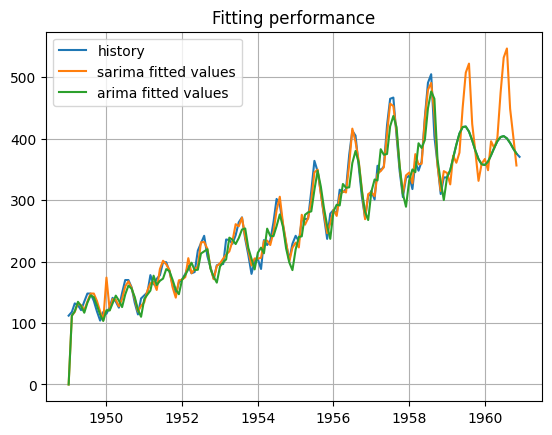

In [225]:
plt.plot(history, label="history")
plt.plot(sarima_model.fittedvalues, label="sarima fitted values")
plt.plot(arima_model.fittedvalues, label="arima fitted values")
plt.grid()
plt.legend()
plt.title("Fitting performance")
plt.show()

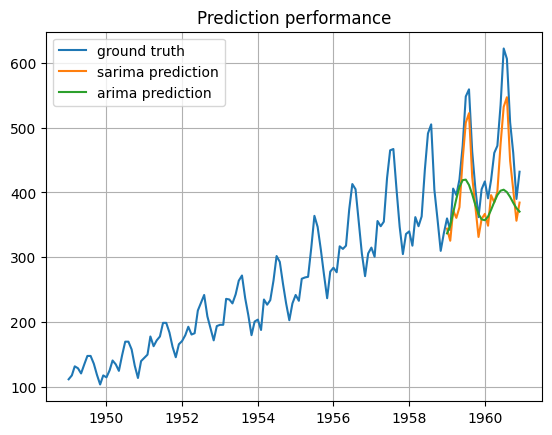

In [226]:
plt.plot(passengers["Passengers"], label="ground truth")
plt.plot(futur, label="sarima prediction")
plt.plot(futur_arima, label="arima prediction")
plt.title("Prediction performance")
plt.grid()
plt.legend()
plt.show()

In [227]:
metrics.mean_squared_error(passengers["Passengers"][120:], futur)

2267.4089212194863

In [228]:
metrics.mean_squared_error(passengers["Passengers"][120:], futur_arima)

8269.764508722505